<a id = "table_of_contents"></a>
# Table of contents

[Import of libraries](#imports)

[Global variables](#global_variables)

[Preprocessing before features generation](#preprocessing_before_fe)

-->[Correct the shop names and id](#correct_shop_names_id)

-->[Generate item_category_features](#generate_item_category_features)

-->[Remove the huge price and item sales outliers](#remove_outliers)

[Generate a full df with all data and records](#generate_full_df_with_all_records)

[Join the full_df with gb_df](#join_dfs)

[Add additional features to our full sales df](#add_new_csvs)

[FeatureGenerator class](#fe_generator_class)

[Generate additional features as, mean and total sales for shop_id , item_id, city ... for every month](#create_new_features)

-->[Date and shop_id features](#feature_1)

--->[Achieving the same result without clases](#only_functions)

-->[Date and item_category features](#feature_3)

-->[Datetime features](#feature_5)

-->[Adding holidays](#feature_6)

[Join full sales df with all the features generated](#join_dfs_with_features)

[Basic model train](#basic_model)

[Feature importance](#feature_importance_1)

[Predict and model evaluation](#predict_and_model_evaluation_1)

[Submission to Kaggle](#submission_kaggle)

[To do](#to_do)

-->[Additional feature 1](#new_feature_1)

-->[Additional feature 2](#new_feature_2)

-->[Additional feature 3](#new_feature_3)

-->[Join df's with new features](#join_dfs_with_new_features)

-->[Model training](#new_model)

-->[Feature importance of new model](#feature_importance_2)

-->[Predict and model evaluation of new model](#predict_and_model_evaluation_2)

<a id = "imports"></a>
# Import of libraries
[Go back to the table of contents](#table_of_contents)

In [1]:
# import the basic libraries we will use in this kernel
import os
import numpy as np
import pandas as pd
import pickle

import time
import datetime
from datetime import datetime
import calendar

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

<a id = "global_variables"></a>
# Global variables
[Go back to the table of contents](#table_of_contents)

In [2]:
# Resample the sales by this parameter
PERIOD = "M"

PATH_DATA = "../input/nuclio08-dsc-0921"

<a id = "preprocessing_before_fe"></a>
# Preprocessing before features generation
[Go back to the table of contents](#table_of_contents)

The idea of this section is very simple. We have seen in our EDA part that there are a lot of missing values.
Our model will benefit a lot if we can supply it a training data, with the missing values being zero. This way, it can learn from more amount of data.

In order to do so, we must perform a cartesian operation over dates x shops x items_id to generate all the possible combinations of months x shops and x items sales.

In this kernel we will only generate this type of features for the items that are present in TEST only.

This will reduce the amount of calculations required. If you have enough memory, we can do this for all possible combinations.

In [3]:
# load all the df we have
shops_df = pd.read_csv(os.path.join(PATH_DATA, "shops.csv"))
items_df = pd.read_csv(os.path.join(PATH_DATA, "items.csv"))
items_category_df = pd.read_csv(os.path.join(PATH_DATA, "item_categories.csv"))
sales_df = pd.read_csv(os.path.join(PATH_DATA, "sales_train.csv"))

<a id = "correct_shop_names_id"></a>
## Correct the shop names and id
[Go back to the table of contents](#table_of_contents)

In [4]:
city_dict = {
    2 : 'Adygea',
    3 : 'Balashikha',
    4 : 'Volzhski',
    5 : 'Vlogda',
    6 : 'Voronezh',
    7 : 'Voronezh',
    8 : 'Voronezh',
    9 : 'Comercio Ambulante',
    11 : 'Zhukovsky',
    12 : 'Tienda Online',
    13 : 'Kazan',
    14 : 'Kazan',
    15 : 'Kaluga',
    16 : 'Kolomna',
    17 : 'Krasnoyarsk',
    18 : 'Krasnoyarsk',
    19 : 'Kursk',
    20 : 'Moscú',
    21 : 'Moscú',
    22 : 'Moscú',
    24 : 'Moscú',
    25 : 'Moscú',
    26 : 'Moscú',
    27 : 'Moscú',
    28 : 'Moscú',
    29 : 'Moscú',
    30 : 'Moscú',
    31 : 'Moscú',
    32 : 'Moscú',
    33 : 'Mytishchi',
    34 : 'Nizhny Novgorod',
    35 : 'Nizhny Novgorod',
    36 : 'Novosibirsk',
    37 : 'Novosibirsk',
    38 : 'Omsk',
    39 : 'Rostov Na Donu',
    40 : 'Rostov Na Donu',
    41 : 'Rostov Na Donu',
    42 : 'San Petersburgo',
    43 : 'San Petersburgo',
    44 : 'Samara',
    45 : 'Samara',
    46 : 'Posad',
    47 : 'Surgut',
    48 : 'Tomsk',
    49 : 'Tyumen',
    50 : 'Tyumen',
    51 : 'Tyumen',
    52 : 'Ufa',
    53 : 'Ufa',
    54 : 'Khimki',
    55 : 'Tienda Online',
    56 : 'Checos',
    57 : 'Yakutsk',
    58 : 'Yakutsk',
    59 : 'Yaroslavl'
}

In [5]:
def fix_shops(shops, city_dict):
    '''
    This function modifies the shops df inplace.
    It correct's 3 shops that we have found to be 'duplicates'
    and also creates a few more features: extracts the city and encodes it using LabelEncoder
    '''
    shops = shops[~shops["shop_id"].isin([0, 1, 10, 23])]

    # replace all the punctuation in the shop_name columns
    shops["shop_name_cleaned"] = shops["shop_name"].apply(lambda s: "".join([x for x in s if x not in punctuation]))
    
    # extract the city name
    shops["city"] = shops["shop_id"].map(city_dict)
    
    # encode it using a simple LabelEncoder
    shops["city_code"] = LabelEncoder().fit_transform(shops['city'])
    
    return shops

In [6]:
# we have seen in our EDA that we have some duplicate shops, let's correct them.
shops_df = fix_shops(shops_df, city_dict)

In [7]:
shops_df.head()

,shop_name,shop_id,shop_name_cleaned,city,city_code
2,"Adygea TC ""mega""",2,Adygea TC mega,Adygea,0
3,"Balashikha TRC ""Octubre-Kinomir""",3,Balashikha TRC OctubreKinomir,Balashikha,1
4,"Volzhski centro comercial ""Volga Mall""",4,Volzhski centro comercial Volga Mall,Volzhski,25
5,"Vlogda SEC ""Mermelada""",5,Vlogda SEC Mermelada,Vlogda,24
6,"Voronezh (Plekhanovskaya, 13)",6,Voronezh Plekhanovskaya 13,Voronezh,26


<a id = "generate_item_category_features"></a>
## Generate item_category_features
[Go back to the table of contents](#table_of_contents)

In [8]:
items_category_df['split'] = items_category_df['item_category_name'].str.split('-')
items_category_df['type'] = items_category_df['split'].map(lambda x: x[0].strip())
items_category_df['type_code'] = LabelEncoder().fit_transform(items_category_df['type'])

# if subtype is nan then type
items_category_df['subtype'] = items_category_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items_category_df['subtype_code'] = LabelEncoder().fit_transform(items_category_df['subtype'])

items_category_df.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Auriculares / Auriculares,0,"[PC , Auriculares / Auriculares]",PC,13,Auriculares / Auriculares,6
1,Accesorios - PS2,1,"[Accesorios , PS2]",Accesorios,1,PS2,35
2,Accesorios - PS3,2,"[Accesorios , PS3]",Accesorios,1,PS3,36
3,Accesorios - PS4,3,"[Accesorios , PS4]",Accesorios,1,PS4,37
4,Accesorios - PSP,4,"[Accesorios , PSP]",Accesorios,1,PSP,39


<a id = "remove_outliers"></a>
## Remove the huge price and item sales outliers
[Go back to the table of contents](#table_of_contents)

In [9]:
sales_df.shape

(275993, 6)

In [10]:
sales_df = sales_df[sales_df["item_price"] < np.percentile(sales_df["item_price"], q = 100)]
sales_df = sales_df[sales_df["item_cnt_day"] < np.percentile(sales_df["item_cnt_day"], q = 100)]

In [11]:
sales_df.shape

(275991, 6)

<a id = "generate_full_df_with_all_records"></a>
# Generate a full df with all data and records
[Go back to the table of contents](#table_of_contents)

In [12]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275991 entries, 0 to 275992
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            275991 non-null  object 
 1   date_block_num  275991 non-null  int64  
 2   shop_id         275991 non-null  int64  
 3   item_id         275991 non-null  int64  
 4   item_price      275991 non-null  float64
 5   item_cnt_day    275991 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 14.7+ MB


In [13]:
type(sales_df["date"].iloc[0])

str

In [14]:
# convert to datetime the date column
# specify the format since otherwise it might give some problems
sales_df["date"] = pd.to_datetime(sales_df["date"], format = "%d.%m.%Y")

In [15]:
# max date in sales is 30.09.2015.
# In the Kaggle competition we are asked to predict the sales for the next month
# this means the sales of October
min_date = sales_df["date"].min()
max_date_sales = sales_df["date"].max()

In [16]:
max_date_sales

Timestamp('2015-09-30 00:00:00')

In [17]:
# how to create a new date
max_date_test = datetime(2015, 10, 31)

In [18]:
# create a date range that begins with the first sale and ends with the last day from our max_date_sales
date_range = pd.date_range(min_date, max_date_sales, freq = "D")
date_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-09-21', '2015-09-22', '2015-09-23', '2015-09-24',
               '2015-09-25', '2015-09-26', '2015-09-27', '2015-09-28',
               '2015-09-29', '2015-09-30'],
              dtype='datetime64[ns]', length=1003, freq='D')

In [19]:
len(date_range)

1003

Our model will benefit a lot if we can train it with the highest granularity (daily sales).

However, as we can see doing this on a local machine is almost impossible since we have almost 27 Million rows.

In [20]:
shops = sorted(list(sales_df["shop_id"].unique()))

# only items present in test
items = sorted(list(sales_df["item_id"].unique()))

cartesian_product = pd.MultiIndex.from_product([date_range, shops, items], names = ["date", "shop_id", "item_id"])
len(cartesian_product)

12387050

In [21]:
# create a date range that begins with the first sale and ends with the last day from our max_date_test
# choosing a weekly or monthly period, we reduce significantly the number of rows
date_range = pd.date_range(min_date, max_date_test, freq = PERIOD)
print("We have a total of {} months".format(len(date_range)))
date_range

We have a total of 34 months


DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31'],
              dtype='datetime64[ns]', freq='M')

In [22]:
cartesian_product = pd.MultiIndex.from_product([date_range, shops, items], names = ["date", "shop_id", "item_id"])
len(cartesian_product)

419900

In [23]:
cartesian_product.to_frame().head(9)

date  shop_id  item_id
date       shop_id item_id                             
2013-01-31 6       30      2013-01-31        6       30
                   31      2013-01-31        6       31
                   32      2013-01-31        6       32
                   33      2013-01-31        6       33
                   464     2013-01-31        6      464
                   472     2013-01-31        6      472
                   482     2013-01-31        6      482
                   486     2013-01-31        6      486
                   491     2013-01-31        6      491

In [24]:
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-03,0,25,2574,399.0,2.0
1,2013-01-05,0,25,2574,399.0,1.0
2,2013-01-07,0,25,2574,399.0,1.0
3,2013-01-08,0,25,2574,399.0,2.0
4,2013-01-10,0,25,2574,399.0,1.0


We will be working with a DataFrame resampled by Months. We must resample the sales_df.

In [25]:
if not os.path.isfile(os.path.join(PATH_DATA, "GROUP_BY_DF.pkl")):
    st = time.time()

    # # add a column with the calculated revenue per day, shop and item
    sales_df["revenue"] = sales_df["item_cnt_day"] * sales_df["item_price"]
    
    # # set index
    gb_df = sales_df.set_index("date")

    # # groupby shop_id and item_id
    gb_df = gb_df.groupby(["shop_id", "item_id"])

    # # resample the sales to a weekly basis
    gb_df = gb_df.resample(PERIOD).agg({'item_cnt_day':np.sum, "item_price":np.mean, "revenue":np.sum})

    # # convert to dataframe and save the full dataframe
    gb_df.reset_index(inplace = True)

    # # save the groupby dataframe
    gb_df.to_pickle("GROUP_BY_DF.pkl")

    et = time.time()

    print("Total time in minutes to preprocess took {}".format((et - st)/60))
    
    gb_df = pd.read_pickle("GROUP_BY_DF.pkl")
    
else:
    gb_df = pd.read_pickle(os.path.join(PATH_DATA, "GROUP_BY_DF.pkl"))

Total time in minutes to preprocess took 0.6418943921724956


In [26]:
gb_df.head()

,shop_id,item_id,date,item_cnt_day,item_price,revenue
0,6,31,2013-02-28,18.0,684.654,12162.2
1,6,31,2013-03-31,6.0,699.000,4194.0
2,6,31,2013-04-30,2.0,699.000,1398.0
3,6,31,2013-05-31,2.0,699.000,1398.0
4,6,31,2013-06-30,1.0,699.000,699.0


<a id = "join_dfs"></a>
# Join the full_df with gb_df
[Go back to the table of contents](#table_of_contents)

Now that we have the sales_df resampled by months, and we have created a cartesian product (all possible combinations of months, shop_id and item_id), let's merge the df.

In [27]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

full_df = pd.merge(full_df, gb_df, on = ['date','shop_id', "item_id"], how = 'left')

# substitution of outliers: negative item counts are set to 0, counts > 20 are set to 20 units
full_df["item_cnt_day"] = np.clip(full_df["item_cnt_day"], 0, 20)

In [28]:
print(full_df.shape)

(419900, 6)


In [29]:
test_index = pd.read_csv(os.path.join(PATH_DATA, "sales_test_no_data.csv"))

In [30]:
# filter only items present in test.
full_df["unique_id"] = full_df["shop_id"].map(str) + "-" + full_df["item_id"].map(str)
full_df = full_df[full_df["unique_id"].isin(test_index["unique_id"].unique())]

In [31]:
print(full_df.shape)

(151096, 7)


In [32]:
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,unique_id
1,2013-01-31,6,31,NaN,NaN,NaN,6-31
2,2013-01-31,6,32,8.0,349.0,2792.0,6-32
3,2013-01-31,6,33,2.0,499.0,998.0,6-33
7,2013-01-31,6,486,NaN,NaN,NaN,6-486
12,2013-01-31,6,806,NaN,NaN,NaN,6-806


In [33]:
full_df.isnull().sum()

date                0
shop_id             0
item_id             0
item_cnt_day    60712
item_price      81666
revenue         60712
unique_id           0
dtype: int64

<a id = "add_new_csvs"></a>
# Add additional features to our full sales df
[Go back to the table of contents](#table_of_contents)

In [34]:
# add shops_df information
full_df = pd.merge(full_df, shops_df, on = "shop_id", how = "left")
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,unique_id,shop_name,shop_name_cleaned,city,city_code
0,2013-01-31,6,31,NaN,NaN,NaN,6-31,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26
1,2013-01-31,6,32,8.0,349.0,2792.0,6-32,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26
2,2013-01-31,6,33,2.0,499.0,998.0,6-33,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26
3,2013-01-31,6,486,NaN,NaN,NaN,6-486,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26
4,2013-01-31,6,806,NaN,NaN,NaN,6-806,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26


In [35]:
# add items_df information
full_df = pd.merge(full_df, items_df, on = "item_id", how = "left")
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,unique_id,shop_name,shop_name_cleaned,city,city_code,item_name,item_category_id
0,2013-01-31,6,31,NaN,NaN,NaN,6-31,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,"007: Coordenadas ""SKAYFOLL» (BD)",37
1,2013-01-31,6,32,8.0,349.0,2792.0,6-32,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,1 + 1,40
2,2013-01-31,6,33,2.0,499.0,998.0,6-33,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,1 + 1 (BD),37
3,2013-01-31,6,486,NaN,NaN,NaN,6-486,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,1C: Contabilidad 8. versión educativa. 8 edición.,73
4,2013-01-31,6,806,NaN,NaN,NaN,6-806,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,1C: Enterprise 8.3. Guía del Desarrollador prá...,49


In [36]:
# add items_category_df information
full_df = pd.merge(full_df, items_category_df, on = "item_category_id", how = "left")
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,unique_id,shop_name,shop_name_cleaned,city,city_code,item_name,item_category_id,item_category_name,split,type,type_code,subtype,subtype_code
0,2013-01-31,6,31,NaN,NaN,NaN,6-31,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,"007: Coordenadas ""SKAYFOLL» (BD)",37,Película - Blu-Ray,"[Película , Blu, Ray]",Película,14,Blu,8
1,2013-01-31,6,32,8.0,349.0,2792.0,6-32,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,1 + 1,40,Película - DVD,"[Película , DVD]",Película,14,DVD,13
2,2013-01-31,6,33,2.0,499.0,998.0,6-33,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,1 + 1 (BD),37,Película - Blu-Ray,"[Película , Blu, Ray]",Película,14,Blu,8
3,2013-01-31,6,486,NaN,NaN,NaN,6-486,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,1C: Contabilidad 8. versión educativa. 8 edición.,73,Programa - 1C: Enterprise 8,"[Programa , 1C: Enterprise 8]",Programa,15,1C: Enterprise 8,0
4,2013-01-31,6,806,NaN,NaN,NaN,6-806,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,26,1C: Enterprise 8.3. Guía del Desarrollador prá...,49,Libros - materiales metódicas 1C,"[Libros , materiales metódicas 1C]",Libros,11,materiales metódicas 1C,61


In [37]:
full_df.isnull().sum()[full_df.isnull().sum() > 0]

item_cnt_day    60712
item_price      81666
revenue         60712
dtype: int64

In [38]:
full_df["item_cnt_day"].fillna(0, inplace = True)
full_df["revenue"].fillna(0, inplace = True)

In [39]:
# projection of prices to null values: backfill (bfill) and frontfill (ffill)
full_df["item_price"] = full_df.groupby(["shop_id", "item_id"])\
.apply(lambda x: x.item_price.bfill()).reset_index(drop = True)

full_df["item_price"] = full_df.groupby(["shop_id", "item_id"])\
.apply(lambda x: x.item_price.ffill()).reset_index(drop = True)

In [40]:
full_df.isnull().sum()

date                    0
shop_id                 0
item_id                 0
item_cnt_day            0
item_price            271
revenue                 0
unique_id               0
shop_name               0
shop_name_cleaned       0
city                    0
city_code               0
item_name               0
item_category_id        0
item_category_name      0
split                   0
type                    0
type_code               0
subtype                 0
subtype_code            0
dtype: int64

In [41]:
full_df["item_price"].fillna(0, inplace = True)

<a id = "fe_generator_class"></a>
# FeatureGenerator class
[Go back to the table of contents](#table_of_contents)

In [42]:
class FeatureGenerator(object):
    
    '''
    This is a helper class that takes a df and a list of features and creates sum, mean, 
    lag features and variation (change over month) features.
    
    '''
    
    def __init__(self, full_df,  gb_list):
        
        '''
        Constructor of the class.
        gb_list is a list of columns that must be in full_df.
        '''
        
        self.full_df = full_df
        self.gb_list = gb_list
        # joins the gb_list, this way we can dinamically create new columns
        # ["date, "shop_id] --> date_shop_id
        self.objective_column_name = "_".join(gb_list)
            
    def generate_gb_df(self):
        
        '''
        This function takes the full_df and creates a groupby df based on the gb_list.
        It creates 2 columns: 
            1. A sum column for every date and gb_list
            2. Mean columns for every_date and gb_list
            
        The resulting df (gb_df_) is assigned back to the FeatureGenerator class as an attribute.
        '''

        def my_agg(full_df_, args):
            
            '''
            This function is used to perform multiple operations over a groupby df and returns a df
            without multiindex.
            '''
            
            names = {
                # you can put here as many columns as you want 
                '{}_sum'.format(args):  full_df_['item_cnt_day'].sum(),
                #'{}_mean_p'.format(args):  full_df_['item_price'].mean(),
                '{}_mean_r'.format(args):  full_df_['revenue'].mean()
                
            }

            return pd.Series(names, index = [key for key in names.keys()])
        
        # the args is used to pass additional argument to the apply function
        gb_df_ = self.full_df.groupby(self.gb_list).apply(my_agg, args = (self.objective_column_name)).reset_index()

        #print(gb_df_.head())
        self.gb_df_ = gb_df_

        
    def return_gb_df(self):  
        
        '''
        This function takes the gb_df_ created in the previous step (generate_gb_df) and creates additional features.
        We create 3 lag features (values from the past).
        And 6 variation features: 3 with absolute values and 3 with porcentual change.
        '''
        
        def generate_shift_features(self, suffix):
            
            '''
            This function is a helper function that takes the gb_df_ and a suffix (sum or mean) and creates the
            additional features.
            '''

            # dinamically creates the features
            # date_shop_id --> date_shop_id_sum if suffix is sum
            # date_shop_id --> date_shop_id_mean if suffix is mean
            name_ = self.objective_column_name + "_" + suffix
            #print(name_)

            self.gb_df_['{}_shift_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(1))
            
            self.gb_df_['{}_shift_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(2))
            
            self.gb_df_['{}_shift_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(3))
             
            #self.gb_df_['{}_shift_4'.format(name_)] =\
            #self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(4))   
            
            #self.gb_df_['{}_shift_5'.format(name_)] =\
            #self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(5))   
            
            #self.gb_df_['{}_shift_6'.format(name_)] =\
            #self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(6))
            
            self.gb_df_['{}_ma_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(1).rolling(3).mean())   
            
            #self.gb_df_['{}_ma_5'.format(name_)] =\
            #self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(1).rolling(5).mean())   
            
            self.gb_df_['{}_ma_6'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(1).rolling(6).mean())   
                        
            #self.gb_df_['{}_ma_12'.format(name_)] =\
            #self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(1).rolling(12).mean())   
            
            self.gb_df_['{}_ma_e'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.ewm(alpha=0.2, adjust=False).mean())             
            
            #self.gb_df_['{}_var_pct_1'.format(name_)] =\
            #self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(2))/x.shift(2))
            
            self.gb_df_['{}_var_pct_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(3))/x.shift(3))
            
            #self.gb_df_['{}_var_pct_3'.format(name_)] =\
            #self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(4))/x.shift(4))
            
        
            self.gb_df_.fillna(-1, inplace = True)

            self.gb_df_.replace([np.inf, -np.inf], -1, inplace = True)
        
        # call the generate_shift_features function with different suffix (sum and mean)
        generate_shift_features(self, suffix = "sum")
        #generate_shift_features(self, suffix = "mean")
        #generate_shift_features(self, suffix = "mean_p")
        generate_shift_features(self, suffix = "mean_r")
    
        return self.gb_df_
        

<a id = "create_new_features"></a>
# Generate additional features as, mean and total sales for shop_id , item_id, city ... for every month
[Go back to the table of contents](#table_of_contents)

<a id = "feature_1"></a>
## Date and shop_id features
[Go back to the table of contents](#table_of_contents)

In [43]:
st = time.time()

gb_list = ["date", "shop_id", "item_id"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

shop_sales_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

2.6525659720102945

In [44]:
shop_sales_features.shape

(151096, 19)

In [45]:
shop_sales_features[shop_sales_features["shop_id"] == 15].head(5)

,date,shop_id,item_id,date_shop_id_item_id_sum,date_shop_id_item_id_mean_r,date_shop_id_item_id_sum_shift_1,date_shop_id_item_id_sum_shift_2,date_shop_id_item_id_sum_shift_3,date_shop_id_item_id_sum_ma_3,date_shop_id_item_id_sum_ma_6,date_shop_id_item_id_sum_ma_e,date_shop_id_item_id_sum_var_pct_2,date_shop_id_item_id_mean_r_shift_1,date_shop_id_item_id_mean_r_shift_2,date_shop_id_item_id_mean_r_shift_3,date_shop_id_item_id_mean_r_ma_3,date_shop_id_item_id_mean_r_ma_6,date_shop_id_item_id_mean_r_ma_e,date_shop_id_item_id_mean_r_var_pct_2
474,2013-01-31,15,486,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
475,2013-01-31,15,839,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
476,2013-01-31,15,1384,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
477,2013-01-31,15,1389,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
478,2013-01-31,15,1406,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0


<a id = "only_functions"></a>
## Achieving the same result without clases
[Go back to the table of contents](#table_of_contents)

Methods of a class can be viewed as functions but attached to a class (hence the self parameter).

If we extact the methods from FeatureGenerator and eliminame all the ***self*** parameter and add a ***return*** clase, we can easily convert the above methods to functions and use them as usually.

In [46]:
def generate_gb_df(full_df_, gb_list):

    '''
    This function thakes the full_df and creates a groupby df based on the gb_list.
    It creates 2 columns: 
        1. A sum column for every date and gb_list
        2. Mean columns for every_date and gb_list

    The resulting df (gb_df_) is assigned back to the FeatureGenerator class as an attribute.
    '''
    objective_column_name = "_".join(gb_list)
    
    def my_agg(full_df_, args):

        '''
        This function is used to perform multiple operations over a groupby df and returns a df
        without multiindex.
        '''

        names = {
            # you can put here as many columns as you want 
            '{}_sum'.format(args):  full_df_['item_cnt_day'].sum(),
   #         '{}_mean'.format(args):  full_df_['item_cnt_day'].ewm(alpha=0.3, adjust=False).mean()
   #         '{}_sum_r'.format(args):  full_df_['revenue'].sum()
   #         '{}_mov_r'.format(args):  full_df_['item_cnt_day'].ewm(alpha=0.3, adjust=False).mean()
   #         '{}_mean_p'.format(args):  full_df_['item_price'].mean()

        }

        return pd.Series(names, index = [key for key in names.keys()])

    # the args is used to pass additional argument to the apply function
    gb_df_ = full_df_.groupby(gb_list).apply(my_agg, args = (objective_column_name)).reset_index()

    return gb_df_

def return_gb_df(gb_df_, gb_list, suffix = "sum"):  

    # dinamically creates the features
    # date_shop_id --> date_shop_id_sum if suffix is sum
    # date_shop_id --> date_shop_id_mean if suffix is mean
    
    objective_column_name = "_".join(gb_list)
    name_ = objective_column_name + "_" + suffix

    gb_df_['{}_shift_1'.format(name_)] =\
    gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: x.shift(1))
    
    gb_df_['{}_shift_2'.format(name_)] =\
    gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: x.shift(2))

    gb_df_['{}_shift_3'.format(name_)] =\
    gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: x.shift(3))

    #gb_df_['{}_shift_4'.format(name_)] =\
    #gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: x.shift(4))

    #gb_df_['{}_shift_5'.format(name_)] =\
    #gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: x.shift(5))

    #gb_df_['{}_shift_6'.format(name_)] =\
    #gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: x.shift(6))
    
    gb_df_['{}_ma_3'.format(name_)] =\
    gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: x.shift(1).rolling(3).mean())   
    
    gb_df_['{}_ma_e'.format(name_)] =\
    gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: x.ewm(alpha=0.2, adjust=False).mean())   
    
    gb_df_['{}_var_pct_1'.format(name_)] =\
    gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(2))/x.shift(2))

    gb_df_['{}_var_pct_2'.format(name_)] =\
    gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(3))/x.shift(3))

    gb_df_['{}_var_pct_3'.format(name_)] =\
    gb_df_.groupby(gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(4))/x.shift(4))

    gb_df_.fillna(-1, inplace = True)

    gb_df_.replace([np.inf, -np.inf], -1, inplace = True)
        
    return gb_df_


#gb_list = ["date", "shop_id", "city_code"]
gb_list = ["date", "shop_id", "item_id"]

gb_df_ = generate_gb_df(full_df_ = full_df, gb_list = gb_list)
gb_df_features_ = return_gb_df(gb_df_ = gb_df_, gb_list = gb_list)

gb_df_features_.head()

,date,shop_id,item_id,date_shop_id_item_id_sum,date_shop_id_item_id_sum_shift_1,date_shop_id_item_id_sum_shift_2,date_shop_id_item_id_sum_shift_3,date_shop_id_item_id_sum_ma_3,date_shop_id_item_id_sum_ma_e,date_shop_id_item_id_sum_var_pct_1,date_shop_id_item_id_sum_var_pct_2,date_shop_id_item_id_sum_var_pct_3
0,2013-01-31,6,31,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
1,2013-01-31,6,32,8.0,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,-1.0,-1.0
2,2013-01-31,6,33,2.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0
3,2013-01-31,6,486,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
4,2013-01-31,6,806,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0


In [47]:
gb_df_features_.sum()

shop_id                               4.821336e+06
item_id                               1.327899e+09
date_shop_id_item_id_sum              3.222490e+05
date_shop_id_item_id_sum_shift_1      3.178050e+05
date_shop_id_item_id_sum_shift_2      3.028490e+05
date_shop_id_item_id_sum_shift_3      2.868950e+05
date_shop_id_item_id_sum_ma_3         2.936963e+05
date_shop_id_item_id_sum_ma_e         3.035581e+05
date_shop_id_item_id_sum_var_pct_1   -8.126185e+04
date_shop_id_item_id_sum_var_pct_2   -8.625717e+04
date_shop_id_item_id_sum_var_pct_3   -9.113501e+04
dtype: float64

In [48]:
shop_sales_features.sum()

shop_id                                  4.821336e+06
item_id                                  1.327899e+09
date_shop_id_item_id_sum                 3.222490e+05
date_shop_id_item_id_mean_r              4.711643e+08
date_shop_id_item_id_sum_shift_1         3.178050e+05
date_shop_id_item_id_sum_shift_2         3.028490e+05
date_shop_id_item_id_sum_shift_3         2.868950e+05
date_shop_id_item_id_sum_ma_3            2.936963e+05
date_shop_id_item_id_sum_ma_6            2.565118e+05
date_shop_id_item_id_sum_ma_e            3.035581e+05
date_shop_id_item_id_sum_var_pct_2      -8.625717e+04
date_shop_id_item_id_mean_r_shift_1      4.711599e+08
date_shop_id_item_id_mean_r_shift_2      4.533918e+08
date_shop_id_item_id_mean_r_shift_3      4.377253e+08
date_shop_id_item_id_mean_r_ma_3         4.495834e+08
date_shop_id_item_id_mean_r_ma_6         4.164154e+08
date_shop_id_item_id_mean_r_ma_e         4.288572e+08
date_shop_id_item_id_mean_r_var_pct_2   -7.031184e+04
dtype: float64

In [49]:
# compare 2 dataframes to see if they are equal
shop_sales_features.equals(gb_df_features_)

False

<a id = "feature_3"></a>
## Date and item_category features
[Go back to the table of contents](#table_of_contents)

In [50]:
st = time.time()

gb_list = ["date", "type_code", "item_id"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

month_type_code_item_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.32324301401774086

In [51]:
month_type_code_item_features.shape

(16796, 19)

In [52]:
st = time.time()

gb_list = ["date", "item_category_id", "item_id"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

month_item_category_item_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.2951639175415039

In [53]:
month_item_category_item_features.shape

(16796, 19)

In [54]:
month_item_category_item_features[month_item_category_item_features["item_category_id"] == 2].head(3)

,date,item_category_id,item_id,date_item_category_id_item_id_sum,date_item_category_id_item_id_mean_r,date_item_category_id_item_id_sum_shift_1,date_item_category_id_item_id_sum_shift_2,date_item_category_id_item_id_sum_shift_3,date_item_category_id_item_id_sum_ma_3,date_item_category_id_item_id_sum_ma_6,date_item_category_id_item_id_sum_ma_e,date_item_category_id_item_id_sum_var_pct_2,date_item_category_id_item_id_mean_r_shift_1,date_item_category_id_item_id_mean_r_shift_2,date_item_category_id_item_id_mean_r_shift_3,date_item_category_id_item_id_mean_r_ma_3,date_item_category_id_item_id_mean_r_ma_6,date_item_category_id_item_id_mean_r_ma_e,date_item_category_id_item_id_mean_r_var_pct_2
0,2013-01-31,2,5572,9.0,4736.666667,-1.0,-1.0,-1.0,-1.0,-1.0,9.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4736.666667,-1.0
1,2013-01-31,2,5574,3.0,2497.000000,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2497.000000,-1.0
2,2013-01-31,2,5637,0.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,-1.0


<a id = "feature_5"></a>
## Datetime features
[Go back to the table of contents](#table_of_contents)

In [55]:
full_df["year"] = full_df["date"].dt.year
full_df["month"] = full_df["date"].dt.month
full_df["days_in_month"] = full_df["date"].dt.days_in_month

<a id = "feature_6"></a>
## Adding holidays
[Go back to the table of contents](#table_of_contents)

In [56]:
holidays_this_month = {
    1:8,
    2:1,
    3:1,
    4:0,
    5:2,
    6:1,
    7:0,
    8:0,
    9:0,
    10:0,
    11:1,
    12:0
}

full_df["holidays_this_month"] = full_df["month"].map(holidays_this_month)

In [57]:
def extract_number_weekends(test_month):
    '''
    Extracts the number of weekend days in a month.
    '''
    saturdays = len([1 for i in calendar.monthcalendar(test_month.year, test_month.month) if i[5] != 0])
    sundays = len([1 for i in calendar.monthcalendar(test_month.year, test_month.month) if i[6] != 0])
    
    return saturdays + sundays

full_df["total_weekend_days"] = full_df["date"].apply(extract_number_weekends)

In [58]:
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,unique_id,shop_name,shop_name_cleaned,city,...,split,type,type_code,subtype,subtype_code,year,month,days_in_month,holidays_this_month,total_weekend_days
0,2013-01-31,6,31,0.0,684.654,0.0,6-31,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,...,"[Película , Blu, Ray]",Película,14,Blu,8,2013,1,31,8,8
1,2013-01-31,6,32,8.0,299.000,2792.0,6-32,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,...,"[Película , DVD]",Película,14,DVD,13,2013,1,31,8,8
2,2013-01-31,6,33,2.0,699.000,998.0,6-33,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,...,"[Película , Blu, Ray]",Película,14,Blu,8,2013,1,31,8,8
3,2013-01-31,6,486,0.0,1959.000,0.0,6-486,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,...,"[Programa , 1C: Enterprise 8]",Programa,15,1C: Enterprise 8,0,2013,1,31,8,8
4,2013-01-31,6,806,0.0,1299.000,0.0,6-806,"Voronezh (Plekhanovskaya, 13)",Voronezh Plekhanovskaya 13,Voronezh,...,"[Libros , materiales metódicas 1C]",Libros,11,materiales metódicas 1C,61,2013,1,31,8,8


<a id = "join_dfs_with_features"></a>
# Join full sales df with all the features generated
[Go back to the table of contents](#table_of_contents)

In [59]:
print("Shape before merge is {}".format(full_df.shape))

full_df = pd.merge(full_df, shop_sales_features, on = ["date", "shop_id", "item_id"], how = "left")
full_df = pd.merge(full_df, month_type_code_item_features, on = ["date", "type_code", "item_id"], how = "left")
full_df = pd.merge(full_df, month_item_category_item_features, on = ["date", "item_category_id", "item_id"], how = "left")
full_df.rename(columns = {"item_cnt_day":"sales"}, inplace = True)

print("Shape after merge is {}".format(full_df.shape))

Shape before merge is (151096, 24)
Shape after merge is (151096, 72)


In [60]:
# save the file

st = time.time()

full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

et = time.time()
(et - st)/60

0.006608784198760986

<a id = "basic_model"></a>
# Basic model train
[Go back to the table of contents](#table_of_contents)

In [61]:
# load the preprocessed data
full_df = pd.read_pickle("FULL_DF_ALL_FEATURES.pkl")
full_df["sales"] = np.clip(full_df["sales"], 0, 20)

# delete all the columns where lags features are - 1 (shift(3))
full_df = full_df[full_df["date"] > np.datetime64("2013-03-31")]

In [62]:
cols_to_drop = [

'revenue',
'shop_name',
"shop_name_cleaned",
"city",
'item_name',
'item_category_name',
'split',
'type',
'subtype',
"unique_id",

# drop the result columns of the additional features
"date_type_code_item_id_sum",
"date_shop_id_item_id_sum",
"date_item_category_id_item_id_sum",
"date_type_code_item_id_mean_r",
"date_shop_id_item_id_mean_r",
"date_item_category_id_item_id_mean_r"
    
]

full_df.drop(cols_to_drop, inplace = True, axis = 1)

In [63]:
full_df.head(3).T

,13332,13333,13334
date,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00
shop_id,6,6,6
item_id,31,32,33
sales,2.0,1.0,0.0
item_price,892.571429,2599.0,299.0
city_code,26,26,26
item_category_id,37,40,37
type_code,14,14,14
subtype_code,8,13,8
year,2013,2013,2013


In [64]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(full_df["date"].unique()))[:-2]   # sales before august

valida_index = [sorted(list(full_df["date"].unique()))[-2]]   # sales in august

test_index = [sorted(list(full_df["date"].unique()))[-1]]   # sales in september

In [65]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = full_df[full_df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = full_df[full_df["date"].isin(train_index)]['sales']

X_valida = full_df[full_df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = full_df[full_df["date"].isin(valida_index)]['sales']

X_test = full_df[full_df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = full_df[full_df["date"].isin(test_index)]['sales']

In [66]:
st = time.time()

model = XGBRegressor(learning_rate = 0.2, max_depth = 4, seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[0]	validation_0-rmse:3.84987	validation_1-rmse:3.54935
[1]	validation_0-rmse:3.29353	validation_1-rmse:3.02056
[2]	validation_0-rmse:2.87306	validation_1-rmse:2.63241
[3]	validation_0-rmse:2.55058	validation_1-rmse:2.34882
[4]	validation_0-rmse:2.29995	validation_1-rmse:2.13079
[5]	validation_0-rmse:2.11243	validation_1-rmse:1.98574
[6]	validation_0-rmse:1.97643	validation_1-rmse:1.88128
[7]	validation_0-rmse:1.86902	validation_1-rmse:1.79276
[8]	validation_0-rmse:1.78282	validation_1-rmse:1.73031
[9]	validation_0-rmse:1.72670	validation_1-rmse:1.70125
[10]	validation_0-rmse:1.67589	validation_1-rmse:1.68128
[11]	validation_0-rmse:1.62403	validation_1-rmse:1.64693
[12]	validation_0-rmse:1.58624	validation_1-rmse:1.62733
[13]	validation_0-rmse:1.56416	validation_1-rmse:1.61576
[14]	validation_0-rmse:1.53744	validation_1-rmse:1.60192
[15]	validation_0-rmse:1.52196	validation_1-rmse:1.59784
[16]	validation_0-rmse:1.50582	validation_1-rmse:1.58821
[17]	validation_0-rmse:1.49428	validation

In [67]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [68]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_02_16_12_07_03.dat


In [69]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

<a id = "feature_importance_1"></a>
# Feature importance
[Go back to the table of contents](#table_of_contents)

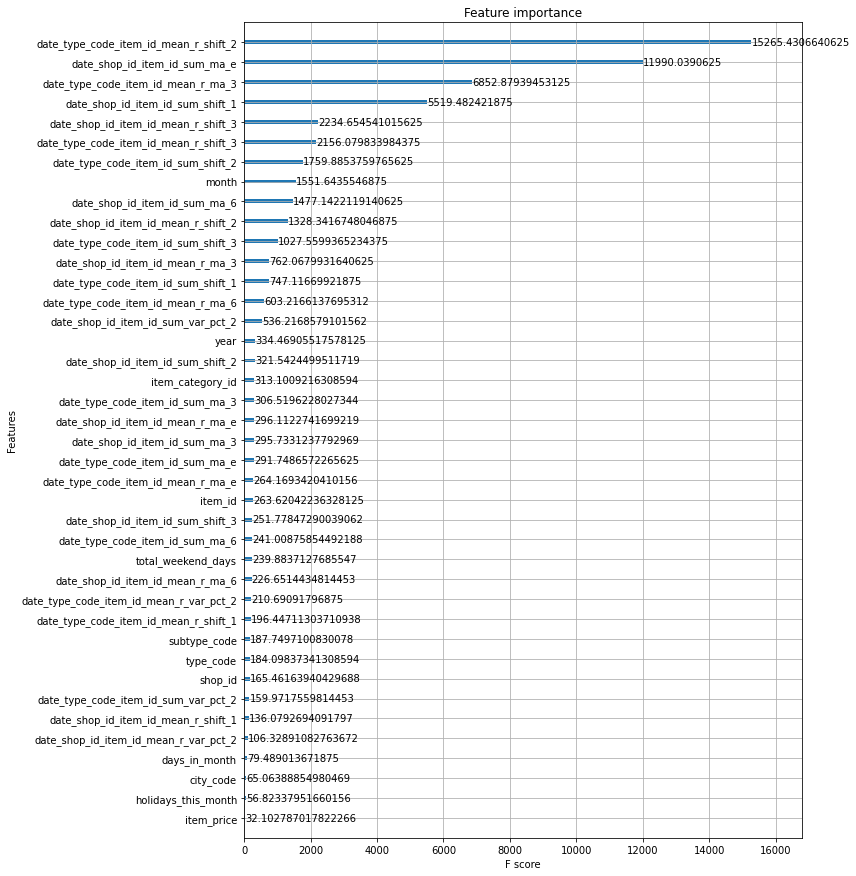

In [70]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

<a id = "predict_and_model_evaluation_1"></a>
# Predict and model evaluation
[Go back to the table of contents](#table_of_contents)

In [71]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

1.4168503211775763

<a id = "submission_kaggle"></a>
# Submission to Kaggle
[Go back to the table of contents](#table_of_contents)

In [72]:
if "sales_predicted" in X_test.columns:
    X_test.drop("sales_predicted", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["sales_predicted"] = np.clip(Y_test_predict, 0, 20)


In [73]:
X_test["unique_id"] = X_test["shop_id"].map(str) + "-" + X_test["item_id"].map(str)

In [74]:
X_test_short = X_test[["unique_id", "sales_predicted"]]

In [75]:
test_index = pd.read_csv(os.path.join(PATH_DATA, "sales_test_no_data.csv"))
test_index["unique_id"] = test_index["unique_id"].map(str)

In [76]:
submission_file = pd.merge(test_index, X_test_short, left_on = "unique_id", right_on = "unique_id", how = "left")
submission_file.drop("sales", axis = 1, inplace = True)
submission_file.rename(columns = {"sales_predicted":"sales"}, inplace = True)

In [77]:
submission_file.isnull().sum()

unique_id    0
sales        0
dtype: int64

In [78]:
submission_file.shape

(4444, 2)

In [79]:
submission_file.to_csv("submission.csv", index = False)

<a id = "to_do"></a>
# To do
[Go back to the table of contents](#table_of_contents)

<a id = "new_feature_1"></a>
# Additional feature 1
[Go back to the table of contents](#table_of_contents)

## Features related to shops

# First new feature: change city by type code
#gb_list = ["date", "shop_id", "type_code"]

# Second new feature: add item_category
#gb_list = ["date", "shop_id", "item_category_id"]

# Third new feature: add revenue
#gb_list = ["date", "shop_id", "revenue"] -> Your notebook tried to allocate more memory than is available. It has restarted.


st = time.time()

gb_list = ["date", "shop_id", "item_category_id"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

shop_sales_features = fe_generator.return_gb_df()

shop_sales_features.drop("item_category_id", axis = 1, inplace = True)
et = time.time()

(et - st)/60

In [ ]:
shop_sales_features.shape

In [ ]:
shop_sales_features[shop_sales_features["shop_id"] == 15].head(5)

<a id = "new_feature_2"></a>
# Additional feature 2
[Go back to the table of contents](#table_of_contents)

In [ ]:
# Features related to items

# First new feature: add type_code
#gb_list = ["date", "item_category_id", "type_code"]

# Second new feature: add revenue
#gb_list = ["date", "item_category_id", "revenue"] -> Your notebook tried to allocate more memory than is available. It has restarted.

# Third new feature: add shop_id
#gb_list = ["date", "item_category_id", "shop_id"] -> Your notebook tried to allocate more memory than is available. It has restarted.


In [ ]:
st = time.time()

gb_list = ["date", "item_category_id", "type_code"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

month_item_category_features = fe_generator.return_gb_df()

month_item_category_features.drop("type_code", axis = 1, inplace = True)
et = time.time()

(et - st)/60

In [ ]:
month_item_category_features.shape

In [ ]:
month_item_category_features[month_item_category_features["item_category_id"] == 2].head(3)

<a id = "new_feature_3"></a>
# Additional feature 3
[Go back to the table of contents](#table_of_contents)

In [ ]:
# Datetime features

full_df["year"] = full_df["date"].dt.year
full_df["month"] = full_df["date"].dt.month
full_df["days_in_month"] = full_df["date"].dt.days_in_month

In [ ]:
# Adding holidays

holidays_this_month = {
    1:8,
    2:1,
    3:1,
    4:0,
    5:2,
    6:1,
    7:0,
    8:0,
    9:0,
    10:0,
    11:1,
    12:0
}

full_df["holidays_this_month"] = full_df["month"].map(holidays_this_month)

In [ ]:
def extract_number_weekends(test_month):
    '''
    Extracts the number of weekend days in a month.
    '''
    saturdays = len([1 for i in calendar.monthcalendar(test_month.year, test_month.month) if i[5] != 0])
    sundays = len([1 for i in calendar.monthcalendar(test_month.year, test_month.month) if i[6] != 0])
    
    return saturdays + sundays

full_df["total_weekend_days"] = full_df["date"].apply(extract_number_weekends)

In [ ]:
full_df.head()

<a id = "join_dfs_with_new_features"></a>
# Join df's with new features
[Go back to the table of contents](#table_of_contents)

In [ ]:
# Join full_df with the additional features

print("Shape before merge is {}".format(full_df.shape))

full_df = pd.merge(full_df, shop_sales_features, on = ["date", "shop_id"], how = "left")
full_df = pd.merge(full_df, month_item_category_features, on = ["date", "item_category_id"], how = "left")
full_df.rename(columns = {"item_cnt_day":"sales"}, inplace = True)

print("Shape after merge is {}".format(full_df.shape))

In [ ]:
# Save the file

st = time.time()

full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

et = time.time()
(et - st)/60

<a id = "new_model"></a>
# Model training
[Go back to the table of contents](#table_of_contents)

In [ ]:
# load the preprocessed data
full_df = pd.read_pickle("FULL_DF_ALL_FEATURES.pkl")
full_df["sales"] = np.clip(full_df["sales"], 0, 20)

# delete all the columns where lags features are - 1 (shift(3))
full_df = full_df[full_df["date"] > np.datetime64("2013-03-31")]

In [ ]:
cols_to_drop = [

'revenue',
'shop_name',
"shop_name_cleaned",
"city",
'item_name',
'item_category_name',
'split',
'type',
'subtype',
"unique_id",

# drop the result columns of the additional features
"date_shop_id_item_category_id_sum",
"date_item_category_id_type_code_sum",
    
]

full_df.drop(cols_to_drop, inplace = True, axis = 1)

In [ ]:
full_df.head(3).T

In [ ]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(full_df["date"].unique()))[:-2]   # sales before august

valida_index = [sorted(list(full_df["date"].unique()))[-2]]   # sales in august

test_index = [sorted(list(full_df["date"].unique()))[-1]]   # sales in september

In [ ]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = full_df[full_df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = full_df[full_df["date"].isin(train_index)]['sales']

X_valida = full_df[full_df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = full_df[full_df["date"].isin(valida_index)]['sales']

X_test = full_df[full_df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = full_df[full_df["date"].isin(test_index)]['sales']

In [ ]:
st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

In [ ]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [ ]:
print("{}_{}.dat".format(model_name, t))

In [ ]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

<a id = "feature_importance_2"></a>
# Feature importance of new model
[Go back to the table of contents](#table_of_contents)

In [ ]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

<a id = "predict_and_model_evaluation_2"></a>
# Predict and model evaluation of new model
[Go back to the table of contents](#table_of_contents)

In [ ]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida